# ABS tutorial 06

## template fitting pipeline pre-process

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### read maps

In [2]:
NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True)
map30 = hp.smoothing(map30f+mapcmb,fwhm=fwhm[0])
map95 = hp.smoothing(map95f+mapcmb,fwhm=fwhm[1])
map150 = hp.smoothing(map150f+mapcmb,fwhm=fwhm[2])
map353 = hp.smoothing(map353f+mapcmb,fwhm=fwhm[3])

vmap30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 12.739827 arcmin (0.003706 rad) 
-> fwhm is 30.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 7.643896 arcmin (0.002224 rad) 
-> fwhm is 18.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 5.095931 arcmin (0.001482 rad) 
-> fwhm is 12.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 2.038372 arcmin (0.000593 rad) 
-> fwhm is 4.800000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


### simple likelihood pre-process

- T maps

CPU times: user 1min 51s, sys: 789 ms, total: 1min 52s
Wall time: 33.4 s


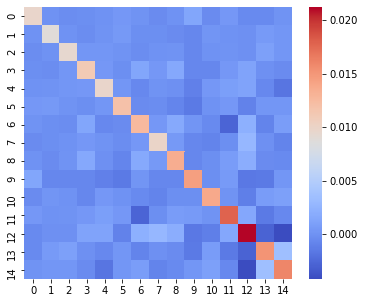

In [3]:
%%time

RESAMP = 20
APOSCALE = 6.
PSBIN = 40

fullmap = dict()
fullmap[95] = map95[0].reshape(1,-1)
fullmap[150] = map150[0].reshape(1,-1)

fullvar = dict()
fullvar[95] = vmap95[0].reshape(1,-1)
fullvar[150] = vmap150[0].reshape(1,-1)

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

tmpmap = dict()
tmpmap[30] = map30f[0].reshape(1,-1)
tmpmap[353] = map353f[0].reshape(1,-1)

tmpbeam = dict()
tmpbeam[30] = fwhm[0]
tmpbeam[353] = fwhm[3]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam,
                      templates=tmpmap,template_fwhms=tmpbeam)
rslt_t = pipeline.preprocess_simple(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(rslt_t[1],cmap='coolwarm',annot=False,ax=ax)

- QU maps

CPU times: user 7min 59s, sys: 3.48 s, total: 8min 3s
Wall time: 2min 27s


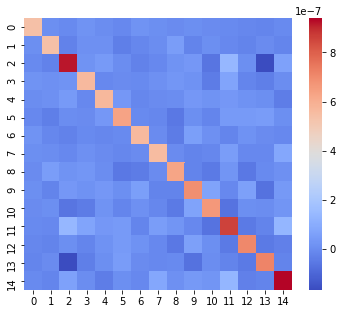

In [4]:
%%time

RESAMP = 20
APOSCALE = 6.
PSBIN = 40

fullmap = dict()
fullmap[95] = map95[1:]
fullmap[150] = map150[1:]

fullvar = dict()
fullvar[95] = vmap95[1:]
fullvar[150] = vmap150[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

tmpmap = dict()
tmpmap[30] = map30f[1:]
tmpmap[353] = map353f[1:]

tmpbeam = dict()
tmpbeam[30] = fwhm[0]
tmpbeam[353] = fwhm[3]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam,
                      templates=tmpmap,template_fwhms=tmpbeam)
rslt_eb = pipeline.preprocess_simple(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(rslt_eb[1],cmap='coolwarm',annot=False,ax=ax)

### window function matrix (top-hat according to NaMaster)

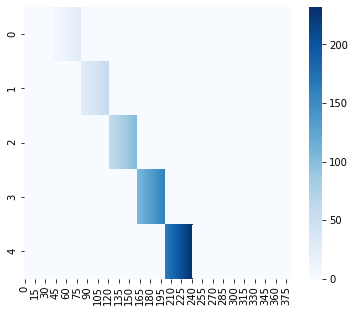

In [5]:
pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam,
                      templates=tmpmap,template_fwhms=tmpbeam)
window = pipeline.bp_window(aposcale=APOSCALE,psbin=PSBIN)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(window,cmap='Blues',annot=False,ax=ax)

end